# CellPy Tutorial

CellPy is a Python-based method of classifying single cell RNA sequencing datasets. The classifier implements the XGBoost algorithm to predict cell types once it is trained on a reference dataset. 

Paper: 

## Pre-CellPy Steps

CellPy requires a normalized expression matrix and metadata as arguments when classifying single cell RNA sequencing datasets. The normalized expression matrix is fed into the command line under the argument **trainNormExpr** or **predNormExpr**. The metadata is fed into the command line under the argument **trainMetadata** or **predMetadata**.

This normalized expression matrix and metadata can be generated through the following R code:

In [ ]:
#R code
# Exporting the Normalized Gene Expression Matrix
library(scrattch.io)
write_dgCMatrix_csv(seurat.object@assays$RNA@data, "~/cellpy_files/normalized_expression.csv")

# Exporting the MetaData For Cross Validation 
seurat.object_metadata = seurat.object@meta.data
seurat.object_metadata = seurat.object_metadata[ , c("Celltype1", "Celltype2", "Celltype3", "Timepoint")]
write.csv(seurat.object_metadata,"~/cellpy_files/metadata.csv")

## CellPy Usage

CellPy has been formatted into a wrapper function that can be easily run through the command line of the Terminal. 

### CellPy Run Option Summary and Examples

CellPy offers 3 different run modes: training, prediction, and feature ranking. Trains on each layer and outputs a new Layer object for each layer....

1a. TrainAll: training all layers w/ cross validation and metrics
* (runMode = trainAll, trainNormExpr, labelInfo, trainMetadata, testSplit, rejectionCutoff)
* Example: `cellpy --runMode trainAll --trainNormExpr /cellpy_example/zheng_pbmc_10K.csv --labelInfo /cellpy_example/zheng_labelinfo.csv --trainMetadata /cellpy_example/zheng_pbmc_10K_metadata.csv --testSplit 0.1 --rejectionCutoff 0.5`

1b. TrainAll: training all layers w/o cross validation and metrics
* (runMode = trainAll, trainNormExpr, labelInfo, trainMetadata, rejectionCutoff)
* Example: `cellpy --runMode trainAll --trainNormExpr /cellpy_example/zheng_pbmc_10K.csv --labelInfo /cellpy_example/zheng_labelinfo.csv --trainMetadata /cellpy_example/zheng_pbmc_10K_metadata.csv --rejectionCutoff 0.5`

2a. PredictOne: prediction of layers w/ val_metadata, each layer is predicted independently
* (runMode = predictOne, predNormExpr, predMetadata, layerObjectPaths, rejectionCutoff)
* Example: `cellpy --runMode predictOne --predNormExpr /cellpy_example/pbmc_10k_normalized.csv --predMetadata /cellpy_example/pbmc_10k_metadata.csv --layerObjectPaths /cellpy_example/cellpy_results_20210720155257/training/Root_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/CD4_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/CD8_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/T-cell_object.pkl --rejectionCutoff 0.5`

2b. PredictOne: prediction of layers w/o val_metadata, each layer is predicted independently
* (runMode = predictOne, predNormExpr, layerObjectPaths, rejectionCutoff)
* Example: `cellpy --runMode predictOne --predNormExpr /cellpy_example/pbmc_10k_normalized.csv --layerObjectPaths /cellpy_example/cellpy_results_20210720155257/training/Root_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/CD4_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/CD8_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/T-cell_object.pkl --rejectionCutoff 0.5`

2c. PredictAll: prediction of layers w/o val_metadata, each layer influences the next layer
* (runMode = predictAll, predNormExpr, layerObjectPaths, rejectionCutoff)
* Example: `cellpy --runMode predictAll --predNormExpr /cellpy_example/pbmc_10k_normalized.csv --layerObjectPaths /cellpy_example/cellpy_results_20210720155257/training/Root_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/CD4_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/CD8_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/T-cell_object.pkl --rejectionCutoff 0.5`

4a. FeatureRankingOne
* (runMode = featureRankingOne, trainNormExpr, trainMetadata, layerObjectPaths, featureRankingSplit)
* Example: `cellpy --runMode featureRankingOne --trainNormExpr /cellpy_example/zheng_pbmc_10K.csv --trainMetadata /cellpy_example/zheng_pbmc_10K_metadata.csv --layerObjectPaths /cellpy_example/cellpy_results_20210720155257/training/Root_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/CD4_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/CD8_object.pkl,/cellpy_example/cellpy_results_20210720155257/training/T-cell_object.pkl --featureRankingSplit 0.1`

### trainAll runMode Option (1a and 1b)

trainAll is a CellPy option that allows the user to train the CellPy algorithm on cell types in their single cell RNA training dataset for use in prediction of their query dataset later. The training of each layer of cell types influences the next.

REQUIRED USER INPUTS:
-  **trainNormExpr**: normalized expression matrix csv file
-  **labelInfo**: label information csv file
-  **trainMetadata**: metadata csv file
-  **testSplit (optional but recommended)**: float between 0 and 1 denoting the amount of data to holdout for evaluating the model
-  **rejectionCutoff**: float between 0 and 1 denoting the minimum probability for a prediction to not be rejected

OUTPUT OF TRAIN ONLY:
* creates directory 'training' in a folder named "cellpy_results_(time)"
* pickel objects (layername.pkl) for each layer trained

#### trainNormExpr

FORMAT: csv file
* contains normalized expression of genes for each single cell 
* first column: gene names
* row headers: cell barcodes
* cells: normalized expression of that particular gene for that particular cell
-  cell 0,0 / A1 is 'gene'
-  first column contains gene names
-  first row contains cell names
-  eg. cell [i,j] is the gene expression value in cell (j-1) for gene (i-1)

EXAMPLE 1:

`gene,AAACCCAG........,AAACGAAC........,AAACGAAT........,GAGGGATC........
MIR1302-10,0,2.14693417019908,2.31409562022533,0
OR4F29,0,1.71783906814673,0,0
LINC00115,0,0,0,2.8499342352407
ISG15,2.99811039595896,0,2.41534932603235,0`

EXAMPLE 2:

In [1]:
import pandas as pd

#example train_normexpr
normexpr = pd.read_csv("~/Desktop/zheng_pbmc_10K.csv", usecols = [0,1,2,3,4])
normexpr

,gene,GCCACTACTCTCCG-6,ATTCTTCTTGGAAA-5,GGCTCACTGGTTAC-6,AAGATGGAGAATCC-1
0,MIR1302-10,0,0,0,0
1,FAM138A,0,0,0,0
2,OR4F5,0,0,0,0
3,RP11-34P13.7,0,0,0,0
4,RP11-34P13.8,0,0,0,0
5,AL627309.1,0,0,0,0
6,RP11-34P13.14,0,0,0,0
7,RP11-34P13.9,0,0,0,0
8,AP006222.2,0,0,0,0


#### labelInfo

FORMAT: csv file
-  explains how each celltype is separated into different layers
-  each column represents a single layer, in the following column the subtypes of that celltype are indicated with the first subtype lying in the same row and all other subtypes filling in the following rows
-  if there are no subtypes for that particular celltype, leave cell in csv empty
-  each column contains the labels at each layers
-  gaps should be left in higher-level layers to denote branching from a given label
* *NOTE: all labels should be unique and should not contain commas*

The labelInfo file is crucial for informing the algorithm the structure of the different layers of cell labels

EXAMPLE 1:

`B-cell,,,,,,,
Basophil,,,,,,,
Dendritic,,,,,,,
Macrophage,,,,,,,
Monocyte,,,,,,,
NK,,,,,,,
Platelet,,,,,,,
T-cell,CD4,Effector Memory CD4,,,,,
,,Naive/Central CD4,,,,,
,,T-reg CD4,,,,,
,CD8,Effector Memory CD8,,,,,
,,Naive CD8,,,,,
,,Temra CD8,,,,,`

In [8]:
#example 1
import pandas as pd
labels = pd.read_csv("~/Desktop/zheng_labelinfo.csv", header=None, usecols = [0,1,2])
labels

,0,1,2
0,B-cell,NaN,NaN
1,Basophil,NaN,NaN
2,Dendritic,NaN,NaN
3,Macrophage,NaN,NaN
4,Monocyte,NaN,NaN
5,NK,NaN,NaN
6,Platelet,NaN,NaN
7,T-cell,CD4,Effector Memory CD4
8,NaN,NaN,Naive/Central CD4
9,NaN,NaN,T-reg CD4


-  layer 1 contains 8 different cell-types: B-cell, Basophil, Dendritic, Macrophage, Monocyte, NK, Platelet, T-cell
-  T-cells are further classified into CD4 and CD8 cells in layer 2
-  CD4 cells are further classified into Effector Memory CD4, Naive/Central CD4, T-reg CD4 in layer 3
-  CD8 cells are further classified into Effector Memory CD8, Naive CD8, Temra CD8 in layer 3
-  *Note: Effector Memory CD4 and Temra CD8 are both layer 3 labels despite having different layer 2 labels*
-  *Note: gaps are left between CD4 and CD8 to make clear to the CellPy algorithm that Naive/Central CD4 and T-reg CD4 belong under the CD4 layer*

EXAMPLE 2 (generic labels):

`Z,,,
A,A1,A1A,
,,A1B,
,A2,A2A,
,,A2B,A2B1
,,,A2B2
,A3,,
,A4,A4A,
,,A4B,
,,A4C,
,A5,,
Y,,,
B,B1,,
,B2,B2A,
,,B2B,
,,B2C,
,,B2D,
,B3,,
,B4,,
C,C1,,
,C2,,
D,,,
E,,,`

In [3]:
#example 2
labels2 = pd.read_csv("~/Desktop/example2labels.csv", header=None)
labels2

,0,1,2,3
0,Z,NaN,NaN,NaN
1,A,A1,A1A,NaN
2,NaN,NaN,A1B,NaN
3,NaN,A2,A2A,NaN
4,NaN,NaN,A2B,A2B1
5,NaN,NaN,NaN,A2B2
6,NaN,A3,NaN,NaN
7,NaN,A4,A4A,NaN
8,NaN,NaN,A4B,NaN
9,NaN,NaN,A4C,NaN


-  layer 1 contains 6 different labels: Z, A, B, C, D, E
-  A cells are further classified into A1, A2, A3, A4, A5 in layer 2
-  B cells are further classified into B1, B2, B3, B4 in layer 2
-  C cells are further classified into C1, C2 in layer 2
-  A1 cells are further classified into A1A, A1B in layer 3
-  A2 cells are further classified into A2A, A2B in layer 3
-  A4 cells are further classified into A4A, A4B, A4C in layer 3
-  B2 cells are further classified into B2A, B2B, B2C, B2D in layer 3
-  A2B cells are further classified into A2B1, A2B2 cells in layer 4

#### trainMetadata

FORMAT: csv file
-  cell 0,0 / A1 should be NA or empty
-  first column contains cell names, should be in the same order as first row of trainNormExpr
-  each column following contains the layered identification for each cell
-  all other cells should be NA or empty
* first column: cell barcodes
* each following column represents a layer of cell subtypes
* a single row contains a cell barcode and then the cell label corresponding to each subtype category

EXAMPLE:

`,Celltype1,Celltype2,Celltype3
AAACCCAG........,Monocyte,NA,NA
AAACGAAC........,NK,NA,NA
AAACGAAT........,Macrophage,NA,NA
GAGGGATC........,T-cell,"CD8,"Effector Memory CD8`

In [12]:
#example train_metadata
import pandas as pd
labels = pd.read_csv("~/Desktop/zheng_pbmc_10K_metadata.csv", nrows=10)
labels

,Unnamed: 0,Celltype1,Celltype2,Celltype3
0,GCCACTACTCTCCG-6,T-cell,CD4,T-reg CD4
1,ATTCTTCTTGGAAA-5,T-cell,CD4,T-reg CD4
2,GGCTCACTGGTTAC-6,T-cell,CD4,Naive/Central CD4
3,AAGATGGAGAATCC-1,T-cell,CD4,Effector Memory CD4
4,ACGATGACGGTGTT-4,NK,NaN,NaN
5,CTATAGCTAGGTTC-3,T-cell,CD4,Naive/Central CD4
6,ACCAGCCTGTACAC-5,T-cell,CD8,Naive CD8
7,TTCCTAGATCGATG-8,Platelet,NaN,NaN
8,TGAGTCGATCGATG-5,T-cell,CD4,Effector Memory CD4
9,CCTCTACTAGGCGA-3,T-cell,CD8,Temra CD8


#### testSplit (Optional but Recommended)

FORMAT: float between 0 and 1
-  a testsplit value of 0.1 means 10% of the data will be held out for testing the model
-  the holdout dataset is stratified and preserves the proportions of the cell labels in the original dataset
If not provided by the user, training will proceed without cross-validation and model evaluation

#### rejectionCutoff

FORMAT: float between 0 and 1
-  a rejection cutoff of 0.5 means a cell will be regarded as "Unclassified" if no class has a predicted probability greater than 50%

### predictOne and predictAll runMode Option (2a, 2b, 2c)

predictOne is a CellPy option that allows the user to use the CellPy algorithm to predict cell types in their single cell RNA query dataset based off of their previously trained dataset. Each layer of cell types is predicted individually from the other layers.

predictAll is a CellPy option that allows the user to use the CellPy algorithm to predict cell types in their single cell RNA query dataset based off of their previously trained dataset. Each layer of cell types predicted influences the predictions for the next layer.

*Note: CellPy creates and stores information from model training in **Layer** objects, including the name of the layer, its depth in metadata files, the dictionary associated with each layer, and the XGBoost model itself. predictOnly and featureRanking run options require **Layer** objects as input and can therefore only be run after **trainAll** has been completed. Details for the **Layer** class can be found at the bottom of this tutorial.*

REQUIRED USER INPUTS:
-  **predNormExpr**: normalized expression matrix file
-  **predMetadata (optional for predictOne, excluded in predictAll)**: metadata file
-  **layerObjectPaths**: a list of path names to Layer objects
-  **rejectionCutoff**: float between 0 and 1 denoting the minimum probability for a prediction to not be rejected

OUTPUT OF PREDICT:
* creates directory 'prediction' in cellpy_results folder, defines 'Root' as topmost layer
* csv files containing all the predictions and probabilities associated with each label for each cell
* metric files detailing accuracy, precision, recall, confusion matrix (if metadata file has been provided in input; only present for predictOne mode)

#### predNormExpr

FORMAT: csv file
-  cell 0,0 / A1 is 'gene'
-  first column contains gene names
-  first row contains cell names
-  eg. cell [i,j] is the gene expression value in cell (j-1) for gene (i-1)

EXAMPLE:

`gene,AAACCCAG........,AAACGAAC........,AAACGAAT........,GAGGGATC........
MIR1302-10,0,2.14693417019908,2.31409562022533,0
OR4F29,0,1.71783906814673,0,0
LINC00115,0,0,0,2.8499342352407
ISG15,2.99811039595896,0,2.41534932603235,0`

#### predMetadata (Optional)

FORMAT: csv file
-  cell 0,0 / A1 should be NA or empty
-  first column contains cell names, should be in the same order as first row of trainNormExpr
-  each column following contains the layered identification for each cell
-  all other cells should be NA or empty

The prediction metadata file option allows the user to test the model on a new dataset.
EXAMPLE:

`,Celltype1,Celltype2,Celltype3
AAACCCAG........,Monocyte,NA,NA
AAACGAAC........,NK,NA,NA
AAACGAAT........,Macrophage,NA,NA
GAGGGATC........,T-cell,"CD8,"Effector Memory CD8`

#### layerObjectPaths

FORMAT: a comma-separated list of paths to the trained Layer objects (pickle .pkl files)
* Layer objects were created by trainOnly
-  not all models have to be provided, can conduct prediction on individual targetted layers
* *NOTE: do not rename the .pkl Layer objects*

EXAMPLE:

`/scratch/groups/smwu/sidraxu/pbmc_10k_metadata.csv --layerObjectPaths /scratch/groups/smwu/sidraxu/cellpy_results_20210720155257/training/Root_object.pkl,/scratch/groups/smwu/sidraxu/cellpy_results_20210720155257/training/CD4_object.pkl,/scratch/groups/smwu/sidraxu/cellpy_results_20210720155257/training/CD8_object.pkl,/scratch/groups/smwu/sidraxu/cellpy_results_20210720155257/training/T-cell_object.pkl`

#### rejectionCutoff

FORMAT: float between 0 and 1
-  a rejection cutoff of 0.5 means a cell will be regarded as "Unclassified" if no class has a predicted probability greater than 50%

### featureRankingOnly runMode Option (3)

*Note: CellPy creates and stores information from model training in **Layer** objects, including the name of the layer, its depth in metadata files, the dictionary associated with each layer, and the XGBoost model itself. predictOnly and featureRanking run options require **Layer** objects as input and can therefore only be run after **trainAll** has been completed. Details for the **Layer** class can be found at the bottom of this tutorial.*

*Note: Feature ranking utilizes the SHAP package and evaluates the importance (Shapley value) of each gene toward the XGBoost models' predictions. The inputted parameters for this option should therefore only be the files used for training for an accurate interpretations of each model.*

REQUIRED USER INPUTS:
-  **trainNormExpr**: normalized expression matrix file
-  **trainMetadata**: metadata file
-  **layerObjectPaths**: a list of path names to Layer objects
-  **featureRankingSplit (optional)**: float between 0 and 1 denoting the percentage of data to calculate SHAP importances, default is 0.3

OUTPUT OF FEATURE RANKING ONLY:
* creates directory 'featureranking' in cellpy_results folder, defining 'Root' as the topmost (first) layer
* graphs with top 10 genes for all classes
* graphs with top 10 genes for each class
* csv file of all shapley values for all genes



#### trainNormExpr

FORMAT: csv file
-  cell 0,0 / A1 is 'gene'
-  first column contains gene names
-  first row contains cell names
-  eg. cell [i,j] is the gene expression value in cell (j-1) for gene (i-1)

EXAMPLE:

`gene,AAACCCAG........,AAACGAAC........,AAACGAAT........,GAGGGATC........
MIR1302-10,0,2.14693417019908,2.31409562022533,0
OR4F29,0,1.71783906814673,0,0
LINC00115,0,0,0,2.8499342352407
ISG15,2.99811039595896,0,2.41534932603235,0`

#### trainMetadata

FORMAT: csv file
-  cell 0,0 / A1 should be NA or empty
-  first column contains cell names, should be in the same order as first row of trainNormExpr
-  each column following contains the layered identification for each cell
-  all other cells should be NA or empty

EXAMPLE:

`,Celltype1,Celltype2,Celltype3
AAACCCAG........,Monocyte,NA,NA
AAACGAAC........,NK,NA,NA
AAACGAAT........,Macrophage,NA,NA
GAGGGATC........,T-cell,"CD8,"Effector Memory CD8`

#### layerObjectPaths

FORMAT: a comma-separated list of paths to the trained Layer objects (pickle .pkl files)
-  not all models have to be provided, can conduct feature ranking on individual targetted layers
* *NOTE: do not rename the .pkl Layer objects*

EXAMPLE:
`/scratch/groups/smwu/sidraxu/pbmc_10k_metadata.csv --layerObjectPaths /scratch/groups/smwu/sidraxu/cellpy_results_20210720155257/training/Root_object.pkl,/scratch/groups/smwu/sidraxu/cellpy_results_20210720155257/training/CD4_object.pkl,/scratch/groups/smwu/sidraxu/cellpy_results_20210720155257/training/CD8_object.pkl,/scratch/groups/smwu/sidraxu/cellpy_results_20210720155257/training/T-cell_object.pkl`

#### featureRankingSplit (Optional, Default = 0.3)

FORMAT: float between 0 and 1
-  a rejection cutoff of 0.5 means a cell will be regarded as "Unclassified" if no class has a predicted probability greater than 50%
-  taking into consideration computational limitations, the default value for the amount of data sampled for feature ranking from the training data is 0.3 (30%)
-  the holdout dataset is stratified and preserves the proportions of the cell labels in the original dataset

## Post-CellPy Analysis in R

The output of the PredictOne and PredictAll modes of CellPy includes a CSV file containing the cell barcodes and the corresponding celltype labels.

This CSV file can be added to the metadata of the test dataset Seurat Object for UMAP and ViolinPlot visualization in R.

In [ ]:
#R-Analysis of CellPy PredictAll CSV output file
#Example containing three celltype layers

library(Seurat)

#finds number of layers + 1 (cell barcode)
numcols = max(count.fields("~/StanfordCVI/cellpy/cellpy_results_20210806072152/predictionAll/predictionall_reject0.5.csv", sep = ','))
#numcols=4 ;(barcode + 3 layers)

prediction = read.table("~/StanfordCVI/cellpy/cellpy_results_20210806072152/predictionAll/predictionall_reject0.5.csv", header = FALSE, sep = ",", 
           col.names = paste0("V",seq_len(numcols)), fill = TRUE)

cellpy_preds = data.frame(prediction)
head(cellpy_preds)

#replace blanks in dataframe with <NA>
cellpy_preds1 <- cellpy_preds
cellpy_preds1[cellpy_preds1 == ""] <- NA 


#import Seurat Object of test/query scRNA dataset
pbmc10k = readRDS("~/Downloads/pbmc10K.final.rds")

#add Celltype1_pred, Celltype2_pred, etc. metadata slots to the Seurat Object
pbmc10k[["Celltype1_pred"]] <- cellpy_preds1$V2
pbmc10k[["Celltype2_pred"]] <- cellpy_preds1$V3
pbmc10k[["Celltype3_pred"]] <- cellpy_preds1$V4

#UMAPs of predictions
DimPlot(pbmc10k, group.by="Celltype1_pred", reduction = "umap", label = TRUE, pt.size = 0.5) +NoLegend()
DimPlot(pbmc10k, group.by="Celltype2_pred", reduction = "umap", label = TRUE, pt.size = 0.5) +NoLegend()
DimPlot(pbmc10k, group.by="Celltype3_pred", reduction = "umap", label = TRUE, pt.size = 0.5) +NoLegend()


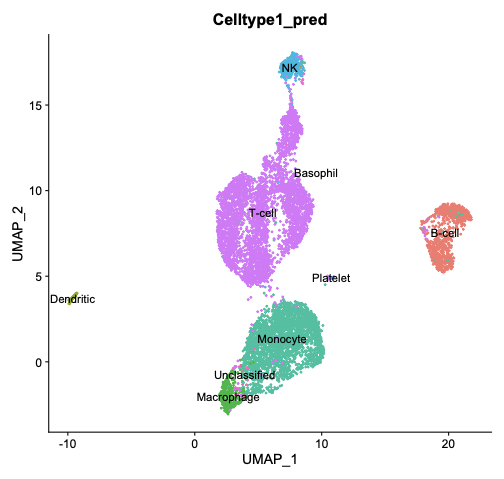

## CellPy Code

### Required dependencies

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import time
import resource 
import sys
import getopt
import os
import datetime
import csv
import pickle
import numpy as np
import pandas as pd
import random
import xgboost as xgb
import matplotlib.pyplot as plt
import itertools
from numpy import interp
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import shap

Ensures given files satisfy one of the possible pathways provided by cellpy

Ensures user input for train or predict matches file inputs

Certain files must appear together for training and/or validation to proceed


In [ ]:
def check_combinations(user_train, user_predict1, user_predict2, user_fr, train_normexpr, labelinfo, train_metadata, testsplit,
                       rejection_cutoff, val_normexpr, val_metadata, layer_paths, frsplit):
    passed = True
    if user_train is None:
        print('ERROR: Run mode must be provided to resume')
        
    # if the user selected the 'trainAll' option
    train_list = [train_normexpr, labelinfo, train_metadata, testsplit, rejection_cutoff]
    if user_train is True:
        print('Training option selected')
        if train_list[0] is None:
            print('ERROR: Normalized expression matrix for training must be provided to resume')
            passed = False
        if train_list[1] is None:
            print('ERROR: Label information file must be provided to resume')
            passed = False
        if train_list[2] is None:
            print('ERROR: Metadata file for training must be provided to resume')
            passed = False
        if train_list[3] is None:
            print('WARNING: Test split amount not provided, training will proceed w/o cross-validation and metric calculations')
        if train_list[4] is None:
            print('ERROR: Rejection cutoff value must be provided to resume')
            passed = False
    
    # if the user selected the 'predictOne' or 'predictAll' options
    predict_list = [val_normexpr, val_metadata, layer_paths, rejection_cutoff]
    if (user_predict1 is True) or (user_predict2 is True):
        if val_metadata is not None and user_predict1 is True:
            print('Independent prediction option with accuracy calculation selected')
        elif val_metadata is not None and user_predict2 is True:
            print('WARNING: Dependent prediction option does not conduct accuracy calculation, provided metadata file will not be used')
        elif val_metadata is None and user_predict1 is True:
            print('Independent prediction option without accuracy calculation selected')
        elif val_metadata is None and user_predict1 is True:
            print('Dependent prediction option selected')
        if predict_list[0] is None:
            print('ERROR: Normalized expression matrix for prediction must be provided to resume')
            passed = False
        if predict_list[2] is None:
            print('ERROR: Path names to Layer objects must be provided to resume')
            passed = False
        if predict_list[3] is None:
            print('ERROR: Rejection cutoff value must be provided to resume')
            passed = False
    
    # if the user selected the 'featureRankingOne' option
    fr_list = [train_normexpr, train_metadata, layer_paths, frsplit]
    if user_fr is True:
        if fr_list[0] is None:
            print('ERROR: Normalized expression matrix for training must be provided to resume')
            passed = False
        if fr_list[1] is None:
            print('ERROR: Metadata file for training must be provided to resume')
            passed = False
        if fr_list[2] is None:
            print('ERROR: Path names to Layer objects must be provided to resume')
            passed = False
        if fr_list[3] is None:
            print('WARNING: Feature ranking split not provided but feature ranking on, will be automatically set to 0.3')
    return passed

Ensures all the user given variables for training exist or are in bounds


In [ ]:
def check_trainingfiles(train_normexpr, labelinfo, train_metadata, testsplit, rejection_cutoff):
    passed = True
    if not os.path.exists(train_normexpr):
        print('ERROR: Given normalized expression data file for training does not exist')
        passed = False
    if not os.path.exists(labelinfo):
        print('ERROR: Given label info file does not exist')
        passed = False
    if not os.path.exists(train_metadata):
        print('ERROR: Given metadata file for training does not exist')
        passed = False
    if testsplit is not None and (testsplit > 1 or testsplit < 0):
        print('ERROR: Given test split percentage must be a value between 0 and 1')
        passed = False
    if rejection_cutoff > 1 or rejection_cutoff < 0:
        print('ERROR: Given rejection cutoff must be a value between 0 and 1')
        passed = False
    return passed

### Training

Conducts training in all layers separated into different folders by name

Creates directory 'training' in cellpy_results folder, defines 'Root' as topmost layer

Conducts finetuning on Root layer with 50 iterations

In [ ]:
def training(train_normexpr, labelinfo, train_metadata, testsplit, rejection_cutoff):
    global path
    path = os.path.join(path, 'training')
    os.mkdir(path)
    os.chdir(path)
    csv2pkl(train_normexpr)
    train_normexpr = train_normexpr[:-3] + 'pkl'
    all_layers = [Layer('Root', 0)]
    construct_tree(labelinfo, all_layers)
    print(all_layers)
    for layer in all_layers:
        path = os.path.join(path, layer.name.replace(' ', ''))
        os.mkdir(path)
        os.chdir(path)
        path = path + '/'
        if layer.name == 'Root': # root top layer
            parameters = layer.finetune(2, testsplit, train_normexpr, train_metadata)
            print(parameters)
        layer.train_layer(train_normexpr, train_metadata, parameters, testsplit, [0, rejection_cutoff])
        os.chdir('..') # return to training directory
        path = os.getcwd()
    path = path + '/'
    training_summary(all_layers)
    export_layers(all_layers)
    print('Training Complete')
    os.chdir('..') # return to cellpy directory
    path = os.getcwd()

Converts the normalized expression csv into a pkl
Expression CSV file must contain genes as row names, samples as column names
First column name (cell A1) is 'gene'

In [ ]:
def csv2pkl(csvpath):
    tp = pd.read_csv(csvpath, iterator=True, chunksize=1000)
    norm_express = pd.concat(tp, ignore_index=True)
    print (norm_express.head())
    norm_express.set_index('gene', inplace=True)
    norm_express.index.names = [None]
    norm_express = norm_express.T
    norm_express.to_pickle(csvpath[:-3] + 'pkl')


Constructs a list of all Layer objects from a labelinfo file
Initalizes each Layer object with a name, level #, and label dictionary

In [ ]:
def construct_tree(labelinfo, all_layers):
    labeldata = fill_data(labelinfo)
    fill_dict(labeldata, all_layers)

Function of construct_tree, fills the vertical columns of the labeldata file


In [ ]:
def fill_data(labelinfo):
    labeldata = list(csv.reader(open(labelinfo, encoding='utf-8-sig')))
    for i in range(1,len(labeldata)):
        if labeldata[i][0]=='':
            labeldata[i][0] = labeldata[i-1][0]
    for i in range(1,len(labeldata)):
        for j in range(1,len(labeldata[0])):
            if labeldata[i][j]=='' and labeldata[i][j-1]==labeldata[i-1][j-1]:
                labeldata[i][j] = labeldata[i-1][j]
    return labeldata

Function of construct_tree after fill_data, reads the edited / filled labeldata file

Constructs the main list structure and initializes all Layer objects in it


In [ ]:
def fill_dict(labeldata, all_layers):
    for i in range(len(labeldata)):
        # Fills the root dictionary
        if find_layer(all_layers, labeldata[i][0]) is None:
            root_layer = find_layer(all_layers, 'Root')
            root_layer.add_dictentry(labeldata[i][0])
        # Fills dictionaries in other layers given the existence of a leaf
        for j in range(1,len(labeldata[0])):
            if labeldata[i][j]!='':
                if find_layer(all_layers, labeldata[i][j-1]) is None:
                    all_layers.append(Layer(labeldata[i][j-1], j))
                prev_layer = find_layer(all_layers, labeldata[i][j-1])
                prev_layer.add_dictentry(labeldata[i][j])
            else:
                break


Utility function of fill_dict, searches all_layers for a layer with the given name

In [ ]:
def find_layer(all_layers, name):
    for layer in all_layers:
        if layer.name == name:
            return layer
    return None

Summarizes and lists the path names of all the files created during training
Prints the summary of each Layer object

In [ ]:
def training_summary(all_layers):
    f = open(path + 'training_summaryfile.txt', 'w')
    for layer in all_layers:
        f.write(str(layer))
        f.write('\n')


Exports all the trained Layers as pickle files

In [ ]:
def export_layers(all_layers):
    for layer in all_layers:
        with open(path + layer.name + '_object.pkl', 'wb') as output:
            pickle.dump(layer, output, pickle.HIGHEST_PROTOCOL)


### Prediction

Ensures all the user given variables for validation exist / are in the correct format


In [ ]:
def check_predictionfiles(layer_paths, val_normexpr, val_metadata=None):
    passed = True
    # check all layer paths are objects and contain a trained xgb model
    for i in range(len(layer_paths)):
        layer_path = layer_paths[i]
        if not os.path.exists(layer_path):
            print('ERROR: Given Layer object ' + str(i) + ' does not exist')
            passed = False
        else:
            layer = pd.read_pickle(layer_path)
            if layer.trained() is False:
                print('ERROR: Given Layer object ' + str(i) + ' is not trained')
                passed = False
    if not os.path.exists(val_normexpr):
        print('ERROR: Given validation normalized expression data file for prediction does not exist')
        passed = False
    if val_metadata != None and not os.path.exists(val_metadata):
        print('ERROR: Given validation metadata file for prediction does not exist')
        passed = False
    return passed

Conducts prediction in specified layers separated into different folders by name

Creates directory 'predictionOne' in cellpy_results folder, defines 'Root' as topmost layer

In [ ]:
def prediction1(val_normexpr, val_metadata, object_paths):
    global path
    path = os.path.join(path, 'predictionOne')
    os.mkdir(path)
    os.chdir(path)
    all_layers = import_layers(object_paths)
    featurenames = all_layers[0].xgbmodel.feature_names
    reorder_pickle(val_normexpr, featurenames)
    val_normexpr = val_normexpr[:-3] + 'pkl'
    for layer in all_layers:
        path = os.path.join(path, layer.name.replace(' ', ''))
        os.mkdir(path)
        os.chdir(path)
        path = path + '/'
        layer.predict_layer([0, rejection_cutoff], val_normexpr, val_metadata)
        os.chdir('..') # return to prediction directory
        path = os.getcwd()
    print('Prediction Complete')
    os.chdir('..') # return to cellpy directory
    path = os.getcwd()

Conducts prediction in all layers in one folder

Creates directory 'predictionAll' in cellpy_results folder, defines 'Root' as topmost layer

In [ ]:
def prediction2(val_normexpr, object_paths):
    global path
    path = os.path.join(path, 'predictionAll')
    os.mkdir(path)
    os.chdir(path)
    path = path + '/'
    
    all_layers = import_layers(object_paths)
    print(all_layers)
    featurenames = all_layers[0].xgbmodel.feature_names
    reorder_pickle(val_normexpr, featurenames)
    val_normexpr = val_normexpr[:-3] + 'pkl'
    
    norm_express = pd.read_pickle(val_normexpr)
    feature_names = list(norm_express)
    print(norm_express.shape)
    X = norm_express.values
    
    X = norm_express.values
    norm_express.index.name = 'cells'
    norm_express.reset_index(inplace=True)
    Y = norm_express.values
    all_cellnames = Y[:,0]
    all_cellnames = all_cellnames.ravel()
    Y = None
    
    f = open(path + 'predictionall_reject' + str(rejection_cutoff) + '.csv','w')
    for i in range(len(all_cellnames)):
        sample = np.array(X[i])#.reshape((-1,1))
        sample = np.vstack((sample, np.zeros(len(feature_names))))
        d_test = xgb.DMatrix(sample, feature_names=feature_names)
        root_layer = find_layer(all_layers, 'Root')
        root_layer.add_dictentry('Unclassified')
        probabilities_xgb = root_layer.xgbmodel.predict(d_test)
        predictions_xgb = probabilities_xgb.argmax(axis=1)
        if probabilities_xgb[0,probabilities_xgb.argmax(axis=1)[0]] < rejection_cutoff:
            predictions_xgb[0] = len(root_layer.labeldict)-1
        f.write(all_cellnames[i])
        f.write(',')
        f.write(root_layer.labeldict[predictions_xgb[0]])
        
        search_str = root_layer.labeldict[predictions_xgb[0]]
        del root_layer.labeldict[len(root_layer.labeldict)-1]
        while(True):
            curr_layer = find_layer(all_layers, search_str)
            if curr_layer is not None:
                curr_layer.add_dictentry('Unclassified')
                probabilities_xgb = curr_layer.xgbmodel.predict(d_test)
                predictions_xgb = probabilities_xgb.argmax(axis=1)
                if probabilities_xgb[0,probabilities_xgb.argmax(axis=1)[0]] < rejection_cutoff:
                    predictions_xgb[0] = len(curr_layer.labeldict)-1
                f.write(',')
                f.write(curr_layer.labeldict[predictions_xgb[0]])
                search_str = curr_layer.labeldict[predictions_xgb[0]]
                del curr_layer.labeldict[len(curr_layer.labeldict)-1]
            else:
                break
        f.write('\n')
    f.close()
    
    print('Prediction Complete')
    os.chdir('..') # return to cellpy directory
    path = os.getcwd()

Imports Layer objects from a list of given paths

In [ ]:
def import_layers(layer_paths):
    layers = []
    for layer_path in layer_paths:
         layer = pd.read_pickle(layer_path)
         layers.append(layer)
    return layers


Converts the normalized expression csv into a pkl

Expression CSV file must contain genes as row names, samples as column names

First column name (cell A1) is 'gene'

Reorders the csv file to match the features in a given featurenames list

Returns path to the new pkl file

In [ ]:
def reorder_pickle(csvpath, featurenames):
    tp = pd.read_csv(csvpath, iterator=True, chunksize=1000)
    norm_express = pd.concat(tp, ignore_index=True)
    print (norm_express.head())
    norm_express.set_index('gene', inplace=True)
    norm_express.index.names = [None]
    norm_express = norm_express.T
    print(norm_express.T.duplicated().any())
    print ('Training Data # of  genes: ' + str(len(featurenames)))
    
    ## Manually reorder columns according to training data index
    # Reorder overlapping genes, remove genes not in training data
    origfeat = list(norm_express)
    print ('Validation Data # of genes: ' + str(len(origfeat)))
    newindex = []
    for i in range(len(featurenames)):
        if featurenames[i] in origfeat:
            newindex.append(featurenames[i])
    print ('Overlapping # of genes: ' + str(len(newindex)))
    norm_express = norm_express.reindex(columns=newindex)
    # Add missing features, remove extra features to match atlas
    i = 0
    missing_counter = 0
    while i < len(list(norm_express)):
        if list(norm_express)[i] != featurenames[i]:
            norm_express.insert(i, featurenames[i], None)
            missing_counter += 1
        i += 1
    while i < len(featurenames):
        norm_express.insert(i, featurenames[i], None)
        i += 1
        missing_counter += 1
    # Overlapping + missing = training total
    print ('Missing # of genes: ' + str(missing_counter))
    norm_express.to_pickle(csvpath[:-3] + 'pkl')

### Feature Ranking

Ensures all the user given variables for training exist or are in bounds

In [ ]:
def check_featurerankingfiles(train_normexpr, train_metadata, layer_paths, frsplit):
    passed = True
    if not os.path.exists(train_normexpr):
        print('ERROR: Given normalized expression data file for training does not exist')
        passed = False
    if not os.path.exists(train_metadata):
        print('ERROR: Given metadata file for training does not exist')
        passed = False
    # check all layer paths are objects and contain a trained xgb model
    if layer_paths != None:
        for i in range(len(layer_paths)):
            layer_path = layer_paths[i]
            if not os.path.exists(layer_path):
                print('ERROR: Given Layer object ' + str(i) + ' does not exist')
                passed = False
            else:
                layer = pd.read_pickle(layer_path)
                if layer.trained() is False:
                    print('ERROR: Given Layer object ' + str(i) + ' is not trained')
                    passed = False
    if frsplit is not None and (frsplit > 1 or frsplit < 0):
        print('ERROR: Given feature ranking split must be a value between 0 and 1')
        passed = False
    return passed


Conducts prediction in all layers separated into different folders by name

Creates directory 'featureranking' in cellpy_results folder, defines 'Root' as topmost layer


In [ ]:
def featureranking(train_normexpr, train_metadata, object_paths, frsplit):
    global path
    path = os.path.join(path, 'featureranking')
    os.mkdir(path)
    os.chdir(path)
    csv2pkl(train_normexpr)
    train_normexpr = train_normexpr[:-3] + 'pkl'
    all_layers = import_layers(object_paths)
    for layer in all_layers:
        path = os.path.join(path, layer.name.replace(' ', ''))
        os.mkdir(path)
        os.chdir(path)
        path = path + '/'
        layer.featurerank_layer(train_normexpr, train_metadata, frsplit)
        os.chdir('..') # return to prediction directory
        path = os.getcwd()
    print('Feature Ranking Complete')
    os.chdir('..') # return to cellpy directory
    path = os.getcwd()

### Layer Class

Object for each layer of the model
Contains methods for subsetting data according to the metadata and label info files,
                     - dividing subsetted data 90-10 and 10 fold cv,
                     - finetuning and training each layer, calculating metrics and SHAP feature ranking,
                     - outputting final model for validation
Keeps track of all outputted files, stores paths and names in instance variables


In [ ]:
class Layer:
    
    # level is the column of the metadata file in which the name of the layer appears
    # xgbmodel is a trained XGBoost classifier object
    # cvmetrics, finalmetrics, cfm, pr are path names to those files
    # predictions, roc, fr are lists of path names
    def __init__(self, name, level, labeldict=None, xgbmodel=None, finetuning=None, cvmetrics=None,
                 finalmetrics=None, predictions=None, cfm=None, roc=None, pr=None, pickle=None):
        self.name = name
        self.level = level
        self.labeldict = {}
        self.xgbmodel = None
        self.finetuning = None
        self.cvmetrics = None
        self.finalmetrics = None
        self.predictions = []
        self.cfm = None
        self.roc = []
        self.pr = None
        self.pickle = self.name + '_object.pkl'
    
    def __hash__(self):
        return hash(self.name)
    
    def __eq__(self, layer2):
        return self.name==layer2.name
    
    def __repr__(self):
        return "<Layer: '%s', Level: %s, labeldict: %s, Trained: %s>" % (self.name, self.level, self.labeldict, self.trained())
    
    def __str__(self):
        return_str = 'Object: ' + self.pickle + '\n'
        return_str += 'Layer: ' + self.name + '\n'
        return_str += 'Level: ' + str(self.level) + '\n'
        return_str += 'Label Dictionary: ' + str(self.labeldict) + '\n'
        if self.finetuned():
            return_str += 'Finetuning Log: ' + self.finetuning + '\n'
        if self.trained():
            return_str += 'XGB Model: ' + self.name + '_xgbmodel.sav' + '\n'
            if self.cvmetrics is not None:
                return_str += '10-Fold Cross Validation Metrics: ' + self.cvmetrics + '\n'
                return_str += 'Final Metrics (10%): ' + self.finalmetrics + '\n'
                return_str += 'Predictions (no rejection): ' + self.predictions[0] + '\n'
                return_str += 'Predictions (' + str(rejection_cutoff) + ' rejection cutoff): ' + self.predictions[1] + '\n'
                return_str += 'Confusion Matrix (10%, no rejection): ' + self.cfm + '\n'
                return_str += 'Micro/Macro ROC Curves: ' + self.roc[0] + '\n'
                return_str += 'Per-Class ROC Curves: ' + self.roc[1] + '\n'
                return_str += 'All Combined ROC Curves: ' + self.roc[2] + '\n'
                return_str += 'Precision-Recall Graph (10%, no rejection): ' + self.pr + '\n'
        return return_str
    
    def finetuned(self):
        return self.finetuning is not None
    
    def trained(self):
        return self.xgbmodel is not None
    
    # Adds a value to the label dictionary if it is not already present
    # Utility function of fill_dict
    def add_dictentry(self, value):
        if value not in list(self.labeldict.values()):
            self.labeldict[len(self.labeldict)] = value


    # Hyperparameter tuning for XGBoost using accuracy
    # Equivalent to sklearn.model_selection.RandomizedSearchCV -- w/o cv and w/ triangular dist
    # Parameters: eta, max_depth, subsamaple, colsample_bytree
    # n randomized trials: triangular distribution around the default or recommended xgboost value
    #                      rounded to a reasonable decimal place
    # Splits data according to user-provided testplit value, NO cross validation conducted
    # Returns parameters with lowest mean absolute error (mae) on 10% for actual training
    # Outputs csv file with accuracy of each class and mae for all trials, does not output any other metrics
    def finetune(self, trials, testsplit, normexprpkl, metadatacsv):
        # If user skips cross validation, testsplit automatically set to 10% for finetuning
        if testsplit is None:
            testsplit = 0.1
        X, Y, X_tr, X_test, Y_tr, Y_test, _ = self.read_data(normexprpkl, metadatacsv, testsplit)
        min_mae = 100000000000000
        f = open(path + self.name + '_finetuning.csv', 'a+')
        f.write('ETA,Max Depth,Subsample,Colsample by Tree,')
        for i in range(len(self.labeldict)):
            f.write(self.labeldict[i] + ' Accuracy')
            f.write(',')
        f.write('MAE\n')
        for i in range(trials):
            eta_temp = round(random.triangular(0,1,0.3),1)
            max_depth_temp = round(random.triangular(4,8,6))
            subsample_temp = round(random.triangular(0.01,1,0.5),1)
            colsample_bytree_temp = round(random.triangular(0.01,1,0.5),1)
            params = {'objective': 'multi:softprob', 'eta': eta_temp, 'max_depth': max_depth_temp, 'subsample': subsample_temp,
                    'colsample_bytree': colsample_bytree_temp, 'eval_metric': 'merror', 'seed': 840}
    
            mae, output_string = self.xgboost_model_shortver(X_tr, X_test, Y_tr, Y_test, params)
            f.write(str(eta_temp) + ',' + str(max_depth_temp) + ',' + str(subsample_temp) + ',' + str(colsample_bytree_temp) + ',')
            f.write(output_string + '\n')
            if mae < min_mae:
                min_mae = mae
                final_params = params
        print(final_params)
        self.finetuning = self.name + '_finetuning.csv'
        return final_params

    # XGBoost w/o cross validation, no output files, just accuracy score on user-provided testsplit value
    # Returns mean absolute error (mae) as float and csv output string
    #       Accuracy for each class and mae in a comma-separated string for classification
    # Only for finetuning!
    def xgboost_model_shortver(self, X_tr, X_test, Y_tr, Y_test, params):
        params['num_class'] = len(self.labeldict)
    
        d_tr = xgb.DMatrix(X_tr, Y_tr, feature_names=feature_names)
        model = xgb.train(params, d_tr, 20, verbose_eval=10)
        d_test = xgb.DMatrix(X_test, Y_test, feature_names=feature_names)
        probabilities_xgb = model.predict(d_test)
    
        returned_str = ''
        predictions_xgb = probabilities_xgb.argmax(axis=1)
        cm = confusion_matrix(Y_test, predictions_xgb)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        mae = 1-sum(cm.diagonal())/len(cm.diagonal())
        returned_str = ','.join(map(str, cm.diagonal())) + ',' + str(mae)
        return mae, returned_str
    
    
    # Trains one layer in the classification
    # Trains XGBoost for a layer of classification given parameters
    # Splits data according to user-provided testsplit
    # Conducts 10-fold cross validation on (1-testsplit)% of data, outputs cv metrics
    # Retrains model on (1-testsplit)% to output metrics when tested on holdout (testsplit)%
    # Retrains final saved model on 100% of data, returns for feature ranking
    # Conducts feature ranking with SHAP if instructed by user on full final model
    def train_layer(self, normexprpkl, metadatacsv, params, testsplit, rejectcutoffs):
        params['num_class'] = len(self.labeldict)
    
        if testsplit is not None:
            # 10-fold CV on (1-testsplit)% of data
            X, Y, X_tr, X_test, Y_tr, Y_test, test_cellnames = self.read_data(normexprpkl, metadatacsv, testsplit)
            kfold = 10
            sss = StratifiedShuffleSplit(n_splits=kfold, test_size=0.1, random_state=720)
            for i, (train_index, test_index) in enumerate(sss.split(X_tr, Y_tr)):
                print('[Fold %d/%d]' % (i + 1, kfold))
                X_train, X_valid = X_tr[train_index], X_tr[test_index]
                Y_train, Y_valid = Y_tr[train_index], Y_tr[test_index]
                d_train = xgb.DMatrix(X_train, Y_train, feature_names=feature_names)
                cv_model = xgb.train(params, d_train, 20, verbose_eval=500)
                self.xgbmodel = cv_model # temporarily set xgbmodel to cv 0.9*(1-testsplit)% model
                self.model_metrics('cv', rejectcutoffs[1], X_valid, Y_valid)
                self.cvmetrics = self.name + '_cvmetrics.txt'
        
            # 90% model, 10% testing
            d_tr = xgb.DMatrix(X_tr, Y_tr, feature_names=feature_names)
            temp_model = xgb.train(params, d_tr, 20, verbose_eval=500)
            self.xgbmodel = temp_model # temporarily set xgbmodel to (1-testsplit)% model
            self.model_metrics('final', rejectcutoffs[1], X_test, Y_test)
            self.finalmetrics = self.name + '_finalmetrics.txt'
            self.cell_predictions('training', rejectcutoffs, test_cellnames, X_test, Y_test)
            for cutoff in rejectcutoffs:
                self.predictions.append(self.name + '_trainingpredictions_reject' + str(cutoff) + '.csv')
            self.cfsn_mtx('training', rejectcutoffs[1], X_test, Y_test)
            self.cfm = self.name + '_confusionmatrix.svg'
            self.roc_curves(X_test, Y_test)
            self.roc.append(self.name + '_miacroroc.svg')
            self.roc.append(self.name + '_classroc.svg')
            self.roc.append(self.name + '_allroc.svg')
            self.pr_curves(X_test, Y_test)
            self.pr = self.name + '_allpr.svg'
    
        # skip cross validation and metric calculations
        if testsplit is None:
            X, Y, all_cellnames = self.read_data(normexprpkl, metadatacsv)
        
        # final 100% model
        d_all = xgb.DMatrix(X, Y, feature_names=feature_names)
        final_model = xgb.train(params, d_all, 20, verbose_eval=500)
        pickle.dump(final_model, open(path + self.name + '_xgbmodel.sav', 'wb'))
        self.xgbmodel = final_model
    
    
    # Outputs predictions of the 90% model on the 10% test set in a given dataset
    # 1 csv file outputted for each rejection cutoff in the list rejectioncutoffs
    # A cutoff of 0.5 means the probability of the label must be >=0.5 for a prediction to be called
    # A cutoff of 0 is equivalent to no rejection option
    def predict_layer(self, rejectcutoffs, normexprpkl, metadatacsv=None):
        X, Y, all_cellnames = self.read_data(normexprpkl, metadatacsv) # Y will be None if metadatacsv=None
        self.cell_predictions('validation', rejectcutoffs, all_cellnames, X, Y) # can handle Y=None
        if metadatacsv != None:
            self.cfsn_mtx('validation', rejectcutoffs[1], X, Y)
            self.model_metrics('validation', rejectcutoffs[1], X, Y)


    # Outputs SHAP feature ranking plots overall and for each class
    # Outputs csv table containing overall SHAP values
    # Uses same procedure for subsetting norm_expr as read_data(...) if column & criterium are provided
    # frsplit automatically set to 0.3 if not provided
    def featurerank_layer(self, normexprpkl, metadatacsv, frsplit):
        norm_express = pd.read_pickle(normexprpkl)
        tp = pd.read_csv(metadatacsv, iterator=True, chunksize=1000)
        labels = pd.concat(tp, ignore_index=True)
        labels.set_index('Unnamed: 0', inplace=True)
        labels.index.names = [None]
        # Only root level will have no subsetcolumn, all other levels require subsetting
        # self.level is one less than what user sees since cellname column is dropped above
        metadata_columns = list(labels.columns.values)
        labelcolumn = metadata_columns[self.level]
        subsetcolumn = metadata_columns[self.level-1] if self.level > 0 else None
        subsetcriterium = self.name
        # Filter out cells if subsetting necessary, keep only data from given criterium
        if subsetcolumn != None:
            # Reindex norm_express and labels based on cell names in given criterium
            temp = labels.loc[labels[subsetcolumn] == subsetcriterium]
            labels = labels.reindex(index=temp.index)
            norm_express = norm_express.reindex(index=temp.index)
        # Remove cells with labels not provided in the dictionary
        temp = labels.loc[labels[labelcolumn].isin(list(self.labeldict.values()))]
        labels = labels.reindex(index=temp.index)
        norm_express = norm_express.reindex(index=temp.index)
        norm_express, labels = shuffle(norm_express, labels)
        if frsplit is None:
            frsplit = 0.3
        if frsplit != 1:
            norm_express = train_test_split(norm_express, labels, test_size=frsplit, random_state=42, shuffle = True, stratify = labels[labelcolumn])[1]
    
        model = self.xgbmodel
        model_bytearray = model.save_raw()[4:]
        model.save_raw = lambda: model_bytearray
        shap_values = shap.TreeExplainer(model).shap_values(norm_express)
        shap.summary_plot(shap_values, norm_express, show=False)
        plt.tight_layout()
        plt.savefig(path + self.name + '_overallfr.svg')
        plt.clf()
        for i in range(len(self.labeldict)):
            shap.summary_plot(shap_values[i], norm_express, show=False)
            plt.tight_layout()
            plt.savefig(path + self.name + '_class'+str(i)+'fr.svg')
            #np.savetxt(path + name + '_class'+str(i)+'fr.csv', shap_values[i], delimiter=",")
            plt.clf()
        
        vals = np.abs(shap_values).mean(0)
        feature_importance = pd.DataFrame(list(zip(norm_express.columns, sum(vals))), columns=['Gene','Feature Importance Value'])
        feature_importance.sort_values(by=['Feature Importance Value'], ascending=False, inplace=True)
        feature_importance.to_csv(path + self.name + '_featureimportances.csv', sep=',', encoding='utf-8')
        
        print('Overall Feature Ranking: ' + self.name + '_overallfr.svg')
        for i in range(len(self.labeldict)):
            print(self.name + '--' + list(self.labeldict.values())[i] + ' Feature Ranking: ' + self.name + '_class'+str(i)+'fr.svg')
        print('Full Feature Importance List: ' + self.name + '_featureimportances.csv')
    

    # Reads the normalized gene expression data into a norm_expr dataframe
    # Reads the specified column in the metadata csv into a label dataframe
    # Metadata CSV file must contain samples as row names, first column name (cell A1) is empty
    # subsetcolumn and subsetcriterium are strings for extracting rows with the specified label in the specified column
    #                                 eg. for per timepoint classification
    #                                 can both be set to None if all samples are to be included
    # Converts norm_expr and label dataframes into numpy arrays X and Y, splits them into 90/10
    # Retrieves cell names of samples in 10% testing data
    # global feature_names defined here, list of all gene names -> should be equivalent for all csvs (except subsetted versions)
    def read_data(self, normexprpkl, metadatacsv=None, testsplit=None):
        norm_express = pd.read_pickle(normexprpkl)
        global feature_names
        feature_names = list(norm_express)
        print(norm_express.shape)
        
        # If validation w/o metadata, metadata not provided, return all data w/o subsetting
        if metadatacsv is None:
            X = norm_express.values
            norm_express.index.name = 'cells'
            norm_express.reset_index(inplace=True)
            Y = norm_express.values
            all_cellnames = Y[:,0]
            all_cellnames = all_cellnames.ravel()
            Y = None
            return X, Y, all_cellnames
        
        tp = pd.read_csv(metadatacsv, iterator=True, chunksize=1000)
        labels = pd.concat(tp, ignore_index=True)
        labels.set_index('Unnamed: 0', inplace=True)
        labels.index.names = [None]
    
        # Only root level will have no subsetcolumn, all other levels require subsetting
        # self.level is one less than what user sees since index is dropped above
        metadata_columns = list(labels.columns.values)
        labelcolumn = metadata_columns[self.level]
        subsetcolumn = metadata_columns[self.level-1] if self.level > 0 else None
        subsetcriterium = self.name
    
        # Filter out cells if subsetting necessary, keep only data from given criterium
        if subsetcolumn != None:
            # Reindex norm_express and labels based on cell names in given criterium
            temp = labels.loc[labels[subsetcolumn] == subsetcriterium]
            labels = labels.reindex(index=temp.index)
            norm_express = norm_express.reindex(index=temp.index)
        # print (labels[labelcolumn].value_counts())
        # Remove cells with labels not provided in the dictionary, replace present keys with values
        temp = labels.loc[labels[labelcolumn].isin(list(self.labeldict.values()))]
        labels = labels.reindex(index=temp.index)
        norm_express = norm_express.reindex(index=temp.index)
        print (labels[labelcolumn].value_counts())
        for i in range(len(self.labeldict)):
            labels = labels.replace(self.labeldict[i],i)
        
        # If validation with metadata, testsplit not provided, return all data w/o train test split
        if testsplit is None:
            X = norm_express.values
            labels.index.name = 'cells'
            labels.reset_index(inplace=True)
            Y = labels.values
            all_cellnames = Y[:,0]
            all_cellnames = all_cellnames.ravel()
            Y = labels[labelcolumn].values
            return X, Y, all_cellnames
        
        X = norm_express.values
        
        # Get cell names in 10% test set - make cell names into a new column to save in a list
        labels.index.name = 'cells'
        labels.reset_index(inplace=True)
        Y = labels.values
        np.random.seed(0)
        X, Y = shuffle(X, Y)
        X_tr, X_test, Y_tr, Y_test = train_test_split(X, Y, test_size=testsplit, random_state=42, shuffle = True, stratify = Y[:,self.level+1])
        test_cellnames = Y_test[:,0]
        test_cellnames = test_cellnames.ravel()

        # Remake train and test split to save X, Y, X_tr, X_test, Y_tr, Y_test
        X = norm_express.values
        Y = labels[labelcolumn].values
        np.random.seed(0)
        X, Y = shuffle(X, Y)
        X_tr, X_test, Y_tr, Y_test = train_test_split(X, Y, test_size=testsplit, random_state=42, shuffle = True, stratify = Y)
        print('Training Samples: ' + str(len(X_tr)) + ', Testing Samples: ' + str(len(X_test)))
        return X, Y, X_tr, X_test, Y_tr, Y_test, test_cellnames;
    
    
    # Calculates metrics of the Layer model on a provided test set and outputs it in a file
    # cv_final_val is a naming string to differentiate between cv, final, and validation metrics
    def model_metrics(self, cv_final_val, rejectcutoff, X_test, Y_test):
        self.add_dictentry('Unclassified')
        d_test = xgb.DMatrix(X_test, Y_test, feature_names=feature_names)
        probabilities_xgb = self.xgbmodel.predict(d_test)
        predictions_xgb = probabilities_xgb.argmax(axis=1)
        for i in range(len(probabilities_xgb)):
            if probabilities_xgb[i,probabilities_xgb.argmax(axis=1)[i]] < rejectcutoff:
                predictions_xgb[i] = len(self.labeldict)-1
        target_names = [str(x) for x in sorted(list(set(Y_test).union(predictions_xgb)))]
        metrics = classification_report(Y_test, predictions_xgb, target_names=target_names)
        with open(path + self.name + '_' + cv_final_val + 'metrics.txt', 'a+') as f:
            print(metrics, file=f)
        del self.labeldict[len(self.labeldict)-1]
    
    
    # Outputs predictions of the Layer model on a provided test set
    # Adds a key value pair in the labeldict for an unclassified class, removes it when completed
    # 1 csv file outputted for each rejection cutoff in the list rejectioncutoffs
    # A cutoff of 0.5 means the probability of the label must be >=0.5 for a prediction to be called
    # A cutoff of 0 is equivalent to no rejection option
    # train_val is a naming string to differentiate between train/test predictions and validation predictions
    def cell_predictions(self, train_val, rejectcutoffs, test_cellnames, X_test, Y_test=None):
        d_test = xgb.DMatrix(X_test, feature_names=feature_names)
        probabilities_xgb = self.xgbmodel.predict(d_test)
        predictions_xgb = probabilities_xgb.argmax(axis=1)
        self.add_dictentry('Unclassified')
        for cutoff in rejectcutoffs:
            counter = 0
            for i in range(len(probabilities_xgb)):
                if probabilities_xgb[i,probabilities_xgb.argmax(axis=1)[i]] < cutoff:
                    predictions_xgb[i] = len(self.labeldict)-1
                    counter += 1
            print('Unclassified # of cells w/ probability cutoff=' + str(cutoff) + ': ' + str(counter))
            f = open(path + self.name + '_' + train_val + 'predictions_reject' + str(cutoff) + '.csv','w')
            if Y_test is not None:
                f.write('Cell ID,True Label,Predicted Label')
            else:
                f.write('Cell ID,Predicted Label')
            for j in range(len(self.labeldict)-1):
                f.write(',')
                f.write(self.labeldict[j] + ' Probability')
            f.write('\n')
            for i in range(test_cellnames.size):
                f.write(test_cellnames[i])
                f.write(',')
                if Y_test is not None:
                    f.write(self.labeldict[Y_test[i]])
                    f.write(',')
                f.write(self.labeldict[predictions_xgb[i]])
                for j in range(len(self.labeldict)-1):
                    f.write(',')
                    f.write(str(probabilities_xgb[i][j]))
                f.write('\n')
            f.close()
        del self.labeldict[len(self.labeldict)-1]
    
    
    # Outputs a confusion matrix of the Layer model's results on a provided test set
    # train_val is a naming string to differentiate between train/test predictions and validation predictions
    def cfsn_mtx(self, train_val, rejectcutoff, X_test, Y_test):
        d_test = xgb.DMatrix(X_test, feature_names=feature_names)
        probabilities_xgb = self.xgbmodel.predict(d_test)
        predictions_xgb = probabilities_xgb.argmax(axis=1)
        self.add_dictentry('Unclassified')
        for i in range(len(probabilities_xgb)):
            if probabilities_xgb[i,probabilities_xgb.argmax(axis=1)[i]] < rejectcutoff:
                predictions_xgb[i] = len(self.labeldict)-1
        cm = confusion_matrix(Y_test, predictions_xgb)
        print(cm)
        del self.labeldict[len(self.labeldict)-1]
        
        for i in range(len(predictions_xgb)-1, -1, -1):
            if predictions_xgb[i] == len(self.labeldict):
                predictions_xgb = np.delete(predictions_xgb, i)
                Y_test = np.delete(Y_test, i)
        cm_removed = confusion_matrix(Y_test, predictions_xgb)
        print(cm_removed)
        classnames = [self.labeldict[x] for x in sorted(list(set(Y_test).union(predictions_xgb)))]
        print(classnames)
        cm_removed = cm_removed.astype('float') / cm_removed.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(15,10))
        plt.imshow(cm_removed, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        tick_marks = np.arange(len(classnames))
        plt.xticks(tick_marks, classnames, rotation=45)
        plt.yticks(tick_marks, classnames)
    
        thresh = cm_removed.max() / 2.
        for i, j in itertools.product(range(cm_removed.shape[0]), range(cm_removed.shape[1])):
            plt.text(j, i, '%0.3f' % cm_removed[i,j] if cm_removed[i,j] > 0 else 0,
                horizontalalignment='center', verticalalignment='center',
                color='white' if cm_removed[i,j] > thresh else 'black', fontsize=6)
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig(path + self.name + '_' + train_val + 'confusionmatrix.svg')
        plt.clf()


    # Creates ROC curves for the Layer model on a provided test set
    # Calculates curves using probability values and thresholds
    # Outputs 3 figures: micro and macro ROC curves, per class ROC curves, and all combined
    def roc_curves(self, X_test, Y_test):
        d_test = xgb.DMatrix(X_test, feature_names=feature_names)
        probabilities_xgb = self.xgbmodel.predict(d_test)
        n_classes = len(self.labeldict)
        lw = 2
    
        # One hot encode Y_test and predictions arrays
        y_test = np.zeros((Y_test.size, Y_test.max()+1))
        y_test[np.arange(Y_test.size),Y_test] = 1
        y_score = probabilities_xgb
    
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
        # Compute macro-average ROC curve and ROC area
    
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
        # Plot micro/macro ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)
    
        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Overall ROC Curves')
        plt.legend(loc="lower right")
        plt.savefig(path + self.name + '_miacroroc.svg')
        plt.clf()
    
        # Plot class ROC curves
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color='#%06X' % random.randint(0, 0xFFFFFF), lw=lw,
                     label='ROC curve of {0} (area = {1:0.2f})'
                     ''.format(self.labeldict[i], roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Class ROC Curves')
        plt.legend(loc="lower right")
        plt.savefig(path + self.name + '_classroc.svg')
        plt.clf()
    
        # Plot all ROC curves
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color='#%06X' % random.randint(0, 0xFFFFFF), lw=lw,
                     label='ROC curve of {0} (area = {1:0.2f})'
                     ''.format(self.labeldict[i], roc_auc[i]))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)
        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('All ROC Curves')
        plt.legend(loc="lower right")
        plt.savefig(path + self.name + '_allroc.svg')
        plt.clf()
    
    
    # Creates precision-recall curves for the Layer model on a provided test set
    # Calculates curves using probability values and thresholds
    # Outputs 1 figure: per class PR curvs and a micro PR curve
    def pr_curves(self, X_test, Y_test):
        d_test = xgb.DMatrix(X_test, feature_names=feature_names)
        probabilities_xgb = self.xgbmodel.predict(d_test)
        n_classes = len(self.labeldict)
        lw = 2
    
        # One hot encode Y_test and predictions arrays
        y_test = np.zeros((Y_test.size, Y_test.max()+1))
        y_test[np.arange(Y_test.size),Y_test] = 1
        y_score = probabilities_xgb
    
        # Compute precision and recall for each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
    
        # Compute micro-average precision and recall
        precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
        average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
    
        # Plot micro + class PR curves
        plt.figure()
        for i in range(n_classes):
            plt.plot(recall[i], precision[i], color='#%06X' % random.randint(0, 0xFFFFFF), lw=lw,
                     label='PR curve of {0} (area = {1:0.2f})'
                     ''.format(self.labeldict[i], average_precision[i]))
        plt.plot(recall["micro"], precision["micro"],
                 label='micro-average PR curve (area = {0:0.2f})'
                       ''.format(average_precision["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('PR Curves')
        plt.legend(loc="lower left")
        plt.savefig(path + self.name + '_allpr.svg')
        plt.clf()


### Main function

Reads in user input, selects a pathway, and trains / predicts


In [ ]:
def main():
    ## CELLPY RUN OPTIONS
    # 1a. training w/ cross validation and metrics
    #       (runMode = trainAll, trainNormExpr, labelInfo, trainMetadata, testSplit, rejectionCutoff)
    # 1b. training w/o cross validation and metrics
    #       (runMode = trainAll, trainNormExpr, labelInfo, trainMetadata, rejectionCutoff)
    # 2a. prediction w/ metadata
    #       (runMode = predictOne, predNormExpr, predMetadata, layerObjectPaths, rejectionCutoff)
    # 2b. prediction w/o metadata, each layer's prediction independent of predictions from other layers
    #       (runMode = predictOne, predNormExpr, layerObjectPaths, rejectionCutoff)
    # 2c. prediction w/o metadata, each layer's prediction influences next layer's prediction
    #       (runMode = predictAll, predNormExpr, layerObjectPaths, rejectionCutoff)
    # 3.  feature ranking
    #       (runMOde = featureRankingOne, trainNormExpr, trainMetadata, layerObjectPaths, featureRankingSplit)
    time_start = time.perf_counter()
    
    # All variables used for training and prediction set to None
    global path, rejection_cutoff
    path = os.getcwd()
    user_train = False
    user_predict1 = False
    user_predict2 = False
    user_fr = False
    train_normexpr = None
    labelinfo = None
    train_metadata = None
    testsplit = None
    frsplit = None
    rejection_cutoff = None
    pred_normexpr = None
    pred_metadata = None
    layer_paths = None
    
    ## Command Line Interface
    # runMode must be 'trainAll', 'predictOne', 'predictAll', or 'featureRankingOne'
    # trainNormExpr, labelInfo, trainMetadata are paths to their respective training files
    # testSplit is a float between 0 and 1 denoting the percentage of data to holdout for testing
    #           if not provided, cross validation is skipped, 100% model trained w/o metrics
    # rejectionCutoff is a float between 0 and 1 denoting the minimum probability for a prediction to not be rejected
    # predNormExpr, predMetadata are paths to their respective prediction files
    # layerObjectPath is a comma-separated list of paths to the Layer objects that the user wants to predict on the predNormExpr
    # featureRankingSplit is a float between 0 and 1 denoting the percentage of data to calculate SHAP importances
    args = sys.argv[1:]
    options, args = getopt.getopt(args, '',
                        ['runMode=', 'trainNormExpr=', 'labelInfo=', 'trainMetadata=', 'testSplit=', 'rejectionCutoff=',
                         'predNormExpr=', 'predMetadata=', 'layerObjectPaths=', 'featureRankingSplit='])
    for name, value in options:
        if name in ['--runMode']:
            if value == 'trainAll':
                user_train = True
            elif value == 'predictOne':
                user_predict1 = True
            elif value == 'predictAll':
                user_predict2 = True
            elif value == 'featureRankingOne':
                user_fr = True
        if name in ['--trainNormExpr']:
            train_normexpr = value
        if name in ['--labelInfo']:
            labelinfo = value
        if name in ['--trainMetadata']:
            train_metadata = value
        if name in ['--testSplit']:
            testsplit = float(value)
        if name in ['--rejectionCutoff']:
            rejection_cutoff = float(value)
        if name in ['--predNormExpr']:
            pred_normexpr = value
        if name in ['--predMetadata']:
            pred_metadata = value
        if name in ['--layerObjectPaths']:
            layer_paths = value.split(',')
        if name in ['--featureRankingSplit']:
            frsplit = float(value)
    
    # Check user provided variables follow an above cellpy pathway
    passed_options = check_combinations(user_train, user_predict1, user_predict2, user_fr, train_normexpr, labelinfo, train_metadata, testsplit,
                                        rejection_cutoff, pred_normexpr, pred_metadata, layer_paths, frsplit)
    if passed_options is False:
        raise ValueError('see printed error log above')
    
    # Create cellpy_results directory with timestamp
    newdir = 'cellpy_results_' + datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    path = os.path.join(path, newdir)
    if not os.path.isdir(path):
        print('Created directory "cellpy_results" in cwdir: ' + path)
        os.mkdir(path)
    os.chdir(path)
    
    # Check training files exist if training option called
    passed_train = None
    passed_predict = None
    passed_fr = None
    if user_train is True:
        passed_train = check_trainingfiles(train_normexpr, labelinfo, train_metadata, testsplit, rejection_cutoff)
    # Check prediction files exist if either of the prediction options is called
    if (user_predict1 is True) or (user_predict2 is True):
        passed_predict = check_predictionfiles(layer_paths, pred_normexpr, pred_metadata)
    # Check feature ranking files exist if feature ranking option called
    if user_fr is True:
        passed_fr = check_featurerankingfiles(train_normexpr, train_metadata, layer_paths, frsplit)
    if (passed_train is False) or (passed_predict is False) or (passed_fr is False):
        raise ValueError('see printed error log above')
        
    # If training option is called and feasible
    if user_train is True and passed_train is True:
        training(train_normexpr, labelinfo, train_metadata, testsplit, rejection_cutoff)
    # If prediction one option is called and feasible
    if user_predict1 is True and passed_predict is True:
        prediction1(pred_normexpr, pred_metadata, layer_paths)
    # If prediction all option is called and feasible
    if user_predict2 is True and passed_predict is True:
        prediction2(pred_normexpr, layer_paths)
    # If feature ranking option is called and feasible
    if user_fr is True and passed_fr is True:
        featureranking(train_normexpr, train_metadata, layer_paths, frsplit)

    # Print computational time and memory required
    time_elapsed = (time.perf_counter() - time_start)
    memMb=resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0/1024.0
    print ("%5.1f secs %5.1f MByte" % (time_elapsed,memMb))
    
    layer = import_layers(['/Users/sidraxu/Documents/GitHub/CellPy/cellpy_results_20210728190956/training/T-cell_object.pkl'])
    model = pickle.load(open('/Users/sidraxu/Documents/GitHub/CellPy/cellpy_results_20210728190956/training/T-cell/T-cell_xgbmodel.sav','rb'))
    layer[0].xgbmodel = model
    export_layers(layer)

In [ ]:
if __name__ == "__main__":
    main()